In [1]:
from torchvision.models.detection import maskrcnn_resnet50_fpn
import glob
import cv2
import torch
import json
import os
import skimage
import matplotlib.pyplot as plt
import numpy as np

import os
from typing import Tuple, List, Sequence, Callable, Dict

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn, Tensor
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import mobilenet_v2
from torchvision.models.detection import keypointrcnn_resnet50_fpn
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.ops import MultiScaleRoIAlign
from torchvision.models.detection import KeypointRCNN,MaskRCNN

import albumentations as A
from albumentations.pytorch import ToTensorV2

(360, 640, 3)
(3, 360, 640)


TypeError: Invalid shape (3, 360, 640) for image data

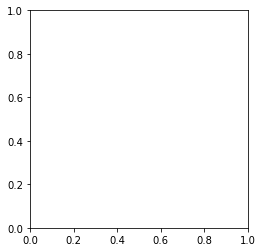

In [2]:
img = cv2.imread( "C:\\Users\\negga\\Desktop\\Mask_RCNN-master\\datasets\pipe\\train\\joint (45).jpg")

print(img.shape)

img=img.transpose(2,0,1)
print(img.shape)
plt.imshow(img)

In [2]:
name_dict = {"surface_damage": 1,"lateral": 2, "debris":3, "joint":4,"crack":5}

In [3]:
from PIL import Image

In [4]:
mmmm=Image.open('C:\\Users\\negga\\Desktop\\Mask_RCNN-master\\datasets\\pipe\\val\\FudanPed00001_mask.png')

mmmm=np.array(mmmm)
print(mmmm.shape)
dd = np.unique(mmmm)

print(dd)

print(dd[1:])

mask=mmmm == dd[:,None,None]

mask=torch.as_tensor(mask,dtype = torch.uint8)

print(mask.shape)

(536, 559)
[0 1 2]
[1 2]
torch.Size([3, 536, 559])


In [5]:
class trainDataset():
    def __init__(self, transforms = None):
        self.root = "C:\\Users\\negga\\Desktop\\Mask_RCNN-master\\datasets\pipe\\train\\"
        self.imgs = glob.glob(self.root+"*.jpg")
        self.transforms = transforms


    def __getitem__(self,idx):
        annotations1 = json.load(open(os.path.join(self.root, "via_region_data.json")))


        annotations = list(annotations1.values())

        annotations = [a for a in annotations if a['regions']]
        
        a=annotations[idx]
        #for i,a in enumerate(annotations):
            
        polygons = [v['shape_attributes'] for r,v in a['regions'].items()] 
        objects = [v['region_attributes']['class'] for r,v in a['regions'].items()]
            
        xcodi = [v['shape_attributes']['all_points_x'] for r,v in a['regions'].items()] 
        ycodi = [v['shape_attributes']['all_points_y'] for r,v in a['regions'].items()]
            
            
        
        #print(i,xcodi[0])
        #print(i,ycodi)
        img_name=a['filename']
        
        img=Image.open(self.root+'\\'+img_name).convert("RGB")
        
        img11 = cv2.imread(self.root+'\\'+img_name,cv2.COLOR_BGR2RGB)
        h,w,c=img11.shape
        #img = torch.as_tensor(img, dtype=torch.float32)
        #print(h,w)
        mask = np.zeros((h,w),dtype= np.uint8)
        for i in range(len(xcodi)):
            rr,cc=skimage.draw.polygon(xcodi[i],ycodi[i])
            mask[cc,rr]=1
            
        
        #색으로 encode된 마스크를 binary masks로 변환---------------------------
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]
        masks = mask == obj_ids[:,None,None]
        
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        #-----------------------------------------------------------------------
        
        
        num_objs = len(obj_ids)
        boxes= []
        #마스크를 통해서 박스 생성--------------------------------------------------
        pos = np.where(mask)
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            if xmin>xmax:
                print(xmin,xmax)
            boxes.append([xmin,ymin,xmax,ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        #----------------------------------------------------------------------------
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((name_dict[objects[0]],), dtype=torch.int64)
        
        #print(area)
        #print(boxes)
        #print(xmin,xmax,ymin,ymax)
        
        """
        plt.subplot(211)
        plt.scatter(xmin,ymin)
        plt.scatter(xmin,ymax)
        plt.scatter(xmax,ymax)
        plt.scatter(xmax,ymin)
        plt.imshow(img)
        plt.subplot(212)
        plt.scatter(xmin,ymin)
        plt.scatter(xmin,ymax)
        plt.scatter(xmax,ymax)
        plt.scatter(xmax,ymin)
        plt.imshow(mask,cmap='gray')
        """
        #클래스 레이블 인덱스-----------------------------
        cls_idx=name_dict[objects[0]]
        cls_idx= torch.tensor([cls_idx],dtype=torch.int64)
        #-------------------------------------------------
        target= {}
        target['labels']=cls_idx
        target['masks']=masks
        target["boxes"]=boxes
        target["area"]=area
        target["image_id"]= torch.tensor([idx])
        if self.transforms is not None:
            img = self.transforms(img)
        return img,target
                
    def __len__(self):
        return len(self.imgs)


In [6]:
import torchvision
from torchvision import transforms

trans = transforms.Compose([transforms.ToTensor(),])

In [7]:
### from typing import Tuple, List, Sequence, Callable, Dict

def collate_fn(batch: torch.Tensor) -> Tuple:
    return tuple(zip(*batch))
traindata=trainDataset(trans)

train_loader = torch.utils.data.DataLoader(traindata, batch_size=3, shuffle=True, num_workers=0, collate_fn=collate_fn)

traindata[130]

(tensor([[[0.0118, 0.0118, 0.0078,  ..., 0.0000, 0.0196, 0.0392],
          [0.0157, 0.0157, 0.0118,  ..., 0.0353, 0.0235, 0.0039],
          [0.1137, 0.1098, 0.1098,  ..., 0.6667, 0.5961, 0.4039],
          ...,
          [0.4196, 0.4275, 0.4392,  ..., 0.7961, 0.7882, 0.3961],
          [0.4196, 0.4314, 0.4392,  ..., 0.7922, 0.7882, 0.3922],
          [0.4196, 0.4314, 0.4431,  ..., 0.7922, 0.7843, 0.3882]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0196, 0.0392],
          [0.0039, 0.0039, 0.0000,  ..., 0.0275, 0.0157, 0.0000],
          [0.0941, 0.0902, 0.0902,  ..., 0.6588, 0.5882, 0.3961],
          ...,
          [0.4078, 0.4157, 0.4275,  ..., 0.7961, 0.7882, 0.3961],
          [0.4078, 0.4196, 0.4275,  ..., 0.7922, 0.7882, 0.3922],
          [0.4078, 0.4196, 0.4314,  ..., 0.7922, 0.7843, 0.3882]],
 
         [[0.0275, 0.0275, 0.0235,  ..., 0.0078, 0.0275, 0.0471],
          [0.0314, 0.0314, 0.0275,  ..., 0.0392, 0.0275, 0.0078],
          [0.1216, 0.1176, 0.1176,  ...,

In [9]:
def get_model():
    model=maskrcnn_resnet50_fpn(pretrained=False, progress=True,
                                num_classes=6, pretrained_backbone=True, trainable_backbone_layers=None)
    # num_classes (int) – number of output classes of the model (including the background)
    # background 포함한 클래수 개수 
    # 1 (background) + 토사퇴적,관파손,연결관,이음부,균열 = 6
    
    
    return model


In [8]:
def get_model() -> nn.Module:
    backbone = resnet_fpn_backbone('resnet101', pretrained=True)
    
    model = MaskRCNN(
        backbone, 
        num_classes=6,
    )

    return model

In [9]:
#from torchvision.models.detection import keypointrcnn_resnet50_fpn

In [10]:
#model=keypointrcnn_resnet50_fpn()

In [11]:
#print(model)

In [12]:
def train(device='cuda:0'):
    model = get_model()
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay= 5e-4)
    #optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)
    num_epochs = 20
    lossList = []
    
    for epoch in range(num_epochs):
        model.train()
        for i, (images, targets) in enumerate(train_loader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            
            optimizer.zero_grad()
            losses = model(images, targets)
            loss = sum(loss for loss in losses.values())
            loss.backward()
            optimizer.step()
            
            if (i+1) % 10 == 0:
                print(f'| epoch: {epoch} | loss: {loss.item():.4f}', end=' | ')
                for k, v in losses.items():
                    print(f'{k[5:]}: {v.item():.4f}', end=' | ')
                print()
                
                
        torch.save(model.state_dict(),'./rcnn_'+str(epoch)+'.pth')
        print()
        print('---------------------------------------------------')
        print()


In [13]:
train()

| epoch: 0 | loss: 2.3768 | classifier: 1.0011 | box_reg: 0.0001 | mask: 0.6822 | objectness: 0.6730 | rpn_box_reg: 0.0205 | 
| epoch: 0 | loss: 1.4779 | classifier: 0.3041 | box_reg: 0.0185 | mask: 0.5711 | objectness: 0.5582 | rpn_box_reg: 0.0260 | 
| epoch: 0 | loss: 1.2564 | classifier: 0.2153 | box_reg: 0.0663 | mask: 0.8145 | objectness: 0.1489 | rpn_box_reg: 0.0114 | 
| epoch: 0 | loss: 1.1302 | classifier: 0.0652 | box_reg: 0.0300 | mask: 0.8260 | objectness: 0.1480 | rpn_box_reg: 0.0611 | 
| epoch: 0 | loss: 0.8150 | classifier: 0.0944 | box_reg: 0.0606 | mask: 0.5876 | objectness: 0.0687 | rpn_box_reg: 0.0036 | 
| epoch: 0 | loss: 0.8527 | classifier: 0.0541 | box_reg: 0.0514 | mask: 0.6623 | objectness: 0.0553 | rpn_box_reg: 0.0296 | 
| epoch: 0 | loss: 0.8107 | classifier: 0.0684 | box_reg: 0.0348 | mask: 0.5825 | objectness: 0.0768 | rpn_box_reg: 0.0482 | 
| epoch: 0 | loss: 0.6258 | classifier: 0.0509 | box_reg: 0.0362 | mask: 0.4531 | objectness: 0.0564 | rpn_box_reg: 0.

| epoch: 7 | loss: 0.8630 | classifier: 0.0635 | box_reg: 0.0557 | mask: 0.6937 | objectness: 0.0341 | rpn_box_reg: 0.0161 | 

---------------------------------------------------

| epoch: 8 | loss: 0.6354 | classifier: 0.0801 | box_reg: 0.0996 | mask: 0.3961 | objectness: 0.0345 | rpn_box_reg: 0.0251 | 
| epoch: 8 | loss: 0.5812 | classifier: 0.0626 | box_reg: 0.0755 | mask: 0.4008 | objectness: 0.0241 | rpn_box_reg: 0.0181 | 
| epoch: 8 | loss: 0.4619 | classifier: 0.0670 | box_reg: 0.0718 | mask: 0.2842 | objectness: 0.0195 | rpn_box_reg: 0.0193 | 
| epoch: 8 | loss: 0.5099 | classifier: 0.0689 | box_reg: 0.0653 | mask: 0.3148 | objectness: 0.0311 | rpn_box_reg: 0.0298 | 
| epoch: 8 | loss: 0.7155 | classifier: 0.0611 | box_reg: 0.0545 | mask: 0.5724 | objectness: 0.0194 | rpn_box_reg: 0.0080 | 
| epoch: 8 | loss: 0.3986 | classifier: 0.0565 | box_reg: 0.0413 | mask: 0.2539 | objectness: 0.0187 | rpn_box_reg: 0.0282 | 
| epoch: 8 | loss: 0.6514 | classifier: 0.0820 | box_reg: 0.0803

| epoch: 15 | loss: 0.4687 | classifier: 0.0535 | box_reg: 0.0521 | mask: 0.3069 | objectness: 0.0259 | rpn_box_reg: 0.0303 | 
| epoch: 15 | loss: 0.4326 | classifier: 0.0619 | box_reg: 0.0732 | mask: 0.2817 | objectness: 0.0087 | rpn_box_reg: 0.0069 | 
| epoch: 15 | loss: 0.3723 | classifier: 0.0805 | box_reg: 0.0683 | mask: 0.1968 | objectness: 0.0148 | rpn_box_reg: 0.0120 | 

---------------------------------------------------

| epoch: 16 | loss: 0.4457 | classifier: 0.0719 | box_reg: 0.0693 | mask: 0.2937 | objectness: 0.0072 | rpn_box_reg: 0.0036 | 
| epoch: 16 | loss: 0.4525 | classifier: 0.0565 | box_reg: 0.0900 | mask: 0.2766 | objectness: 0.0160 | rpn_box_reg: 0.0134 | 
| epoch: 16 | loss: 0.4407 | classifier: 0.0736 | box_reg: 0.0784 | mask: 0.2672 | objectness: 0.0133 | rpn_box_reg: 0.0082 | 
| epoch: 16 | loss: 0.5368 | classifier: 0.0509 | box_reg: 0.0431 | mask: 0.4283 | objectness: 0.0095 | rpn_box_reg: 0.0050 | 
| epoch: 16 | loss: 0.5386 | classifier: 0.0741 | box_reg

In [14]:
torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

device(type='cuda')

In [42]:
image = cv2.imread('C:\\Users\\negga\\Desktop\\Mask_RCNN-master\\datasets\\pipe\\val/25-04229_001_-13.5m.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = image / 255.0
image = image.transpose(2, 0, 1)
image = [torch.as_tensor(image, dtype=torch.float32)]

model = get_model()
model.load_state_dict(torch.load('./rcnn_18.pth'))
model.eval()
preds = model(image)

print(preds)

[{'boxes': tensor([[315.7137, 155.4164, 554.4337, 284.7744],
        [305.7706, 157.8662, 565.2444, 279.5502],
        [280.2588, 172.7955, 560.1707, 292.2016],
        [349.6387, 197.3815, 571.9742, 322.1210],
        [154.1471, 117.4820, 640.0000, 297.2941],
        [213.5411, 179.0135, 625.2839, 359.5948],
        [303.2235, 161.2435, 579.9930, 280.5179],
        [246.3865, 133.5067, 598.7341, 334.2051],
        [343.6743, 208.0370, 582.2829, 314.9558],
        [331.1302, 206.7757, 587.2748, 314.7606],
        [338.5642, 200.5809, 582.6650, 316.0097],
        [471.1051, 158.1564, 536.0238, 360.0000],
        [258.4574, 177.5319, 557.4070, 360.0000],
        [292.8011, 131.7757, 561.3190, 244.2423],
        [473.4949, 141.3042, 530.9958, 360.0000]], grad_fn=<StackBackward>), 'labels': tensor([2, 1, 5, 2, 4, 3, 3, 1, 5, 3, 1, 3, 2, 5, 2]), 'scores': tensor([0.2297, 0.1584, 0.1276, 0.1268, 0.1235, 0.1170, 0.1166, 0.1085, 0.0836,
        0.0831, 0.0811, 0.0676, 0.0675, 0.0644, 0.0610],


<class 'torch.Tensor'>
2


<ipython-input-43-f18d9a8ff366>:20: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.line(image,(boxes[0],boxes[1]),(boxes[0],boxes[3]),(255,0,0))
<ipython-input-43-f18d9a8ff366>:21: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.line(image,(boxes[0],boxes[1]),(boxes[2],boxes[1]),(255,0,0))
<ipython-input-43-f18d9a8ff366>:22: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.line(image,(boxes[2],boxes[1]),(boxes[2],boxes[3]),(255,0,0))
<ipython-input-43-f18d9a8ff366>:23: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using _

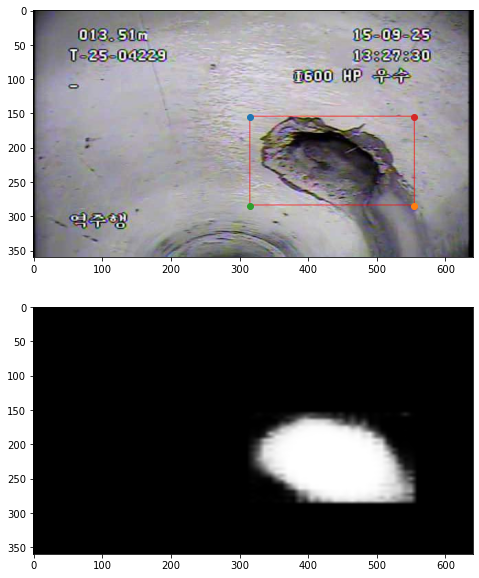

In [43]:
#print(preds[0]['boxes'])
print(type(preds[0]['masks']))
#mask=preds[0]['masks'].detach().numpy()
boxes= preds[0]['boxes'].detach().numpy().copy()[0]
mask = preds[0]['masks'].detach().numpy().copy()[0]
labels = preds[0]['labels'].detach().numpy().copy()[0]
print(labels)
#print(preds)
#print(preds['mask'])
#print(boxes)




image = cv2.imread('C:\\Users\\negga\\Desktop\\Mask_RCNN-master\\datasets\\pipe\\val/25-04229_001_-13.5m.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
mask=mask[0,:,:]


cv2.line(image,(boxes[0],boxes[1]),(boxes[0],boxes[3]),(255,0,0))
cv2.line(image,(boxes[0],boxes[1]),(boxes[2],boxes[1]),(255,0,0))
cv2.line(image,(boxes[2],boxes[1]),(boxes[2],boxes[3]),(255,0,0))
cv2.line(image,(boxes[2],boxes[3]),(boxes[0],boxes[3]),(255,0,0))
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.scatter(boxes[0],boxes[1])
plt.scatter(boxes[2],boxes[3])
plt.scatter(boxes[0],boxes[3])
plt.scatter(boxes[2],boxes[1])
plt.imshow(image)
plt.subplot(212)
plt.imshow(mask,cmap='gray')
#mask=np.array(preds['mask'])

In [17]:
print(mask.tolist())

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

[[[0.89803922 0.85882353 0.82352941]
  [0.89803922 0.85882353 0.82352941]
  [0.89803922 0.85882353 0.82352941]
  ...
  [0.33333333 0.24705882 0.15686275]
  [0.33333333 0.24705882 0.15686275]
  [0.31764706 0.23137255 0.14117647]]

 [[0.89803922 0.85882353 0.82352941]
  [0.89803922 0.85882353 0.82352941]
  [0.89803922 0.85882353 0.82352941]
  ...
  [0.34901961 0.2627451  0.17254902]
  [0.34901961 0.2627451  0.17254902]
  [0.3372549  0.25098039 0.16078431]]

 [[0.89803922 0.85882353 0.82352941]
  [0.89803922 0.85882353 0.82352941]
  [0.89803922 0.85882353 0.82352941]
  ...
  [0.36470588 0.27843137 0.18823529]
  [0.36862745 0.28235294 0.19215686]
  [0.35686275 0.27058824 0.18039216]]

 ...

 [[0.76078431 0.63529412 0.4745098 ]
  [0.76078431 0.63529412 0.4745098 ]
  [0.76078431 0.63529412 0.4745098 ]
  ...
  [0.16470588 0.12156863 0.09803922]
  [0.16862745 0.1254902  0.10196078]
  [0.17254902 0.12941176 0.10588235]]

 [[0.76078431 0.63529412 0.4745098 ]
  [0.76078431 0.63529412 0.4745098 ]


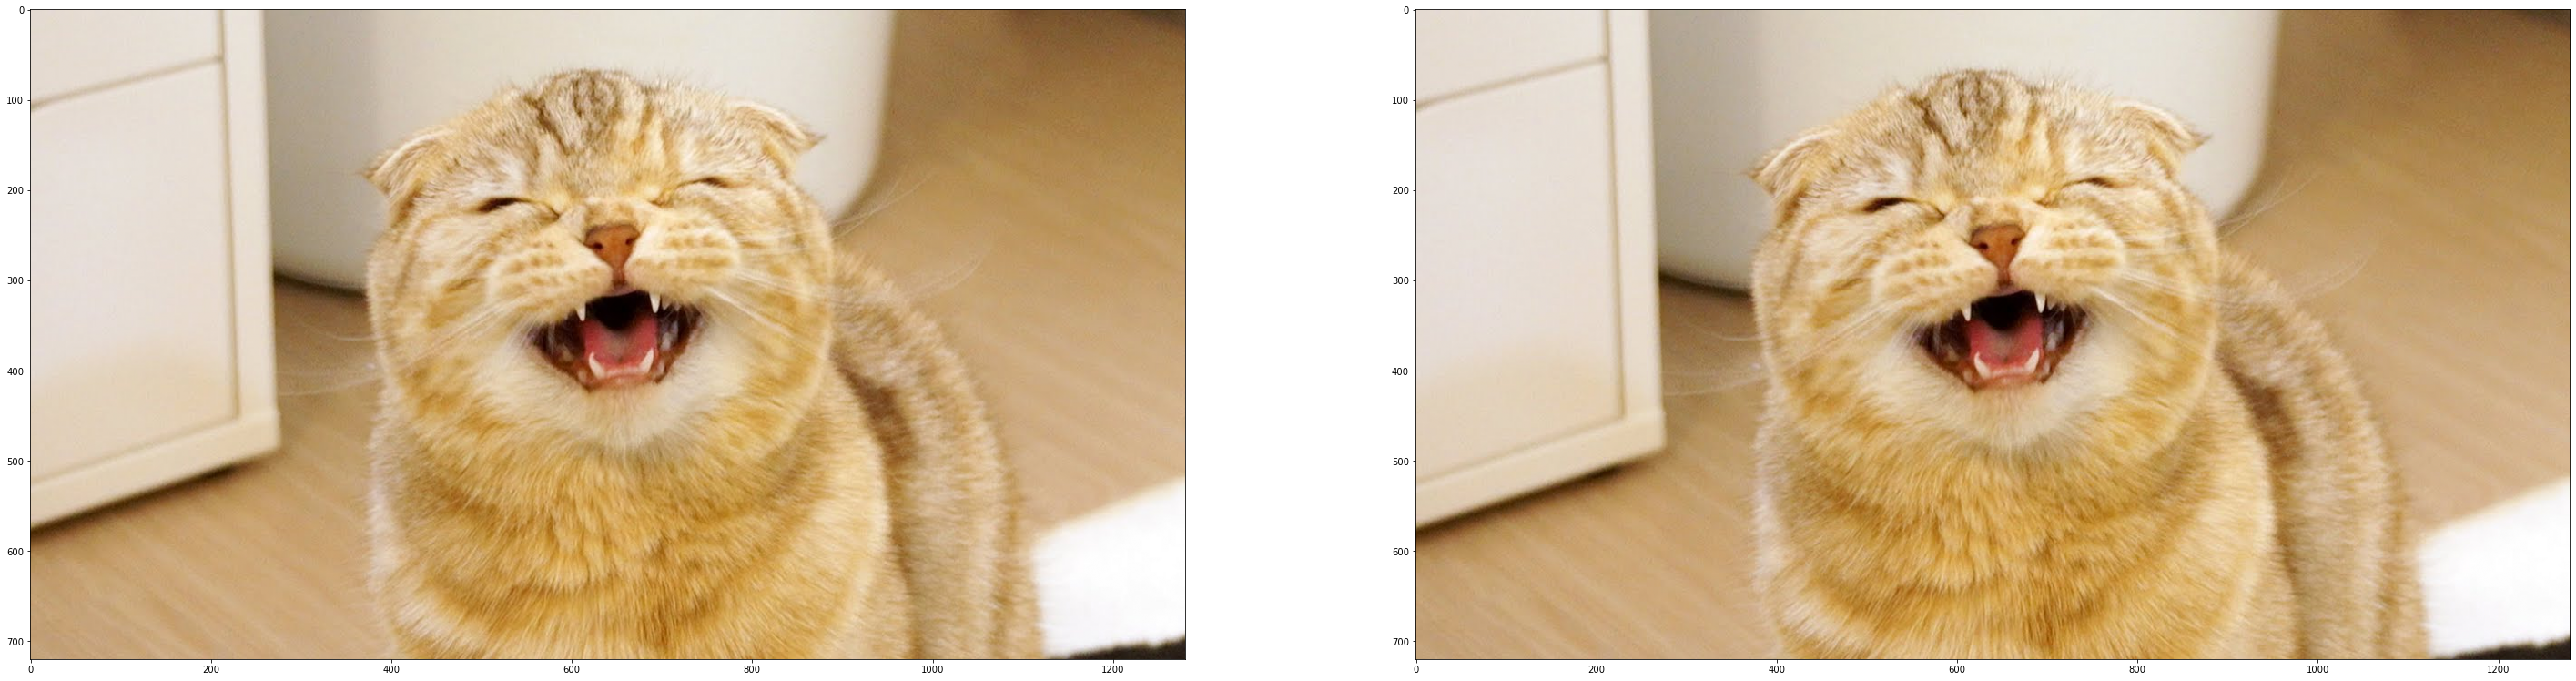

In [57]:
import cv2
from PIL import Image

import matplotlib.pyplot as plt
cvimg=cv2.imread('C:\\Users\\negga\\Desktop\\AiTest\\cat2.jpg')
cvimg=cv2.cvtColor(cvimg,cv2.COLOR_BGR2RGB)
pilimg=Image.open('C:\\Users\\negga\\Desktop\\AiTest\\cat2.jpg').convert("RGB")
pilimg=np.array(pilimg)


cvimg=cvimg/255.0
#print(cvimg/255.0)

pilimg=pilimg/255.0
#print(pilimg/255.0)

print(cvimg)
print('------')
print(pilimg)
fig = plt.figure(figsize=(50, 150))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.imshow(cvimg)
ax2.imshow(pilimg)


